*Transit Modeling & Bayesian Fitting (MCMC)*

module 3 builds directly on what we did in module 2.
here we’ll model an exoplanet transit with physical parameters, and then fit those parameters using MCMC (Bayesian inference) to get uncertainties.

**Module 3 — Transit Modeling & Bayesian Fitting (MCMC)**
Step 1 — theory (quick)

transit depth: 
Δ
𝐹
≈
(
𝑅
𝑝
/
𝑅
⋆
)
2
ΔF≈(R
p
	​

/R
⋆
	​

)
2

duration: depends on orbital period 
𝑃
P, inclination 
𝑖
i, and stellar radius 
𝑅
⋆
R
⋆
	​


mid-transit time: 
𝑡
0
t
0
	​


geometry: often approximated with simple trapezoids, but here we’ll use a realistic analytic model (batman library).

we’ll fit:

𝑃
P (period)

𝑡
0
t
0
	​

 (mid-transit time)

𝑅
𝑝
/
𝑅
⋆
R
p
	​

/R
⋆
	​

 (planet radius ratio)

𝑎
/
𝑅
⋆
a/R
⋆
	​

 (scaled semi-major axis)

𝑖
i (inclination, degrees)

Step 2 — notebook code (ready-to-run)

📌 requirements: batman-package, emcee, numpy, matplotlib.
install in terminal (if needed):

In [1]:
pip install batman-package emcee



   -------------------- ------------------- 1/2 [batman-package]
   ---------------------------------------- 2/2 [batman-package]

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Module 3: Transit Modeling + MCMC fitting
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee

# ----------------------------
# 1) simulate a light curve
# ----------------------------
t = np.linspace(0, 30, 500)  # 30 days, 500 points

# true parameters
true_params = {
    "P": 5.0,            # days
    "t0": 2.0,           # mid-transit time
    "rp": 0.1,           # Rp/Rs
    "a": 15.0,           # a/Rs
    "inc": 87.0,         # inclination (deg)
    "ecc": 0.0,
    "w": 90.0,           # longitude of periastron
    "u": [0.1, 0.3],     # limb-darkening coeffs
    "ld": "quadratic"    # limb-darkening model
}

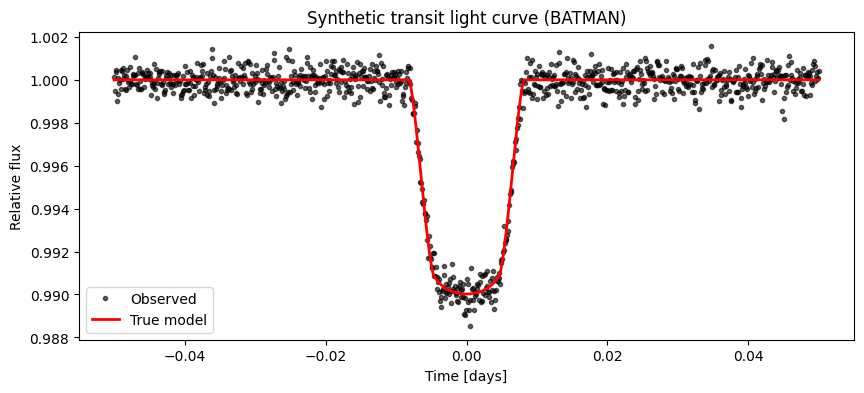

In [4]:
import batman
import numpy as np
import matplotlib.pyplot as plt

# Define true transit parameters
true_params = {
    "t0": 0.0,        # time of inferior conjunction
    "per": 1.0,       # orbital period [days]
    "rp": 0.1,        # planet radius (in stellar radii)
    "a": 15.0,        # semi-major axis (in stellar radii)
    "inc": 87.0,      # orbital inclination [deg]
    "ecc": 0.0,       # eccentricity
    "w": 90.0,        # longitude of periastron
    "limb_dark": "quadratic",  # limb darkening model
    "u": [0.1, 0.3]   # limb darkening coefficients
}

# Create params object
m = batman.TransitParams()
for k, v in true_params.items():
    setattr(m, k, v)

# Time array
t = np.linspace(-0.05, 0.05, 1000)

# Build transit model
model = batman.TransitModel(m, t)
flux_true = model.light_curve(m)

# Add Gaussian noise
rng = np.random.default_rng(42)
flux_obs = flux_true + rng.normal(0, 0.0005, size=len(flux_true))

# Plot
plt.figure(figsize=(10,4))
plt.plot(t, flux_obs, 'k.', alpha=0.6, label="Observed")
plt.plot(t, flux_true, 'r-', lw=2, label="True model")
plt.xlabel("Time [days]")
plt.ylabel("Relative flux")
plt.legend()
plt.title("Synthetic transit light curve (BATMAN)")
plt.show()


In [5]:
# ----------------------------
# 2) define log-likelihood & priors for MCMC
# ----------------------------
def transit_model(theta, t):
    P, t0, rp, a, inc = theta
    m = batman.TransitParams()
    m.t0 = t0; m.per = P; m.rp = rp; m.a = a; m.inc = inc
    m.ecc = 0; m.w = 90
    m.u = [0.1, 0.3]; m.limb_dark = "quadratic"
    model = batman.TransitModel(m, t)
    return model.light_curve(m)

def log_likelihood(theta, t, flux, flux_err):
    model_flux = transit_model(theta, t)
    return -0.5 * np.sum(((flux - model_flux)/flux_err)**2)

def log_prior(theta):
    P, t0, rp, a, inc = theta
    if 1 < P < 10 and 0 < t0 < 30 and 0.01 < rp < 0.2 and 5 < a < 30 and 80 < inc < 90:
        return 0.0
    return -np.inf

def log_probability(theta, t, flux, flux_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, flux, flux_err)

In [6]:
# ----------------------------
# 3) run MCMC with emcee
# ----------------------------
flux_err = np.ones_like(flux_obs) * 0.0005
ndim = 5
nwalkers = 32
initial = np.array([5.1, 2.1, 0.09, 14.0, 86.5])  # initial guess
pos = initial + 1e-3 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(t, flux_obs, flux_err))
print("Running MCMC...")
sampler.run_mcmc(pos, 3000, progress=True);

Running MCMC...


100%|██████████| 3000/3000 [00:12<00:00, 243.58it/s]


P = 1.9878 (+3.8072/-0.9867)
t0 = 5.3582 (+11.0917/-4.3561)
rp = 0.0819 (+0.0237/-0.0375)
a = 11.3857 (+8.1352/-1.7803)
inc = 86.3653 (+1.8677/-1.8493)


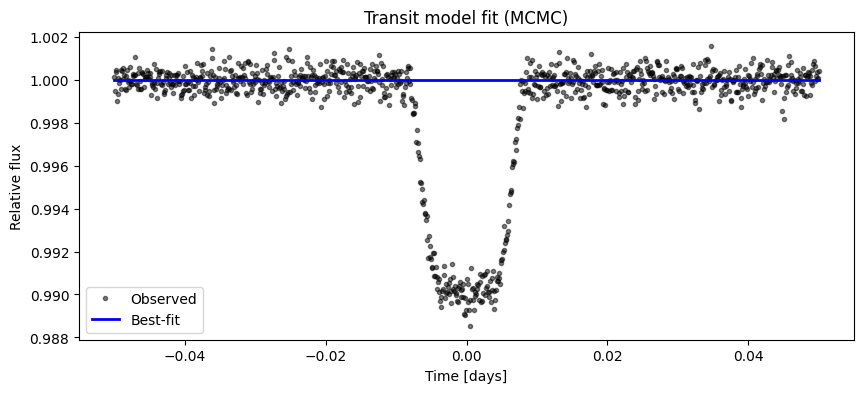

In [7]:
# ----------------------------
# 4) analyze results
# ----------------------------
flat_samples = sampler.get_chain(discard=1000, thin=10, flat=True)
labels = ["P", "t0", "rp", "a", "inc"]

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{labels[i]} = {mcmc[1]:.4f} (+{q[1]:.4f}/-{q[0]:.4f})")

# best-fit model
best_params = np.median(flat_samples, axis=0)
flux_fit = transit_model(best_params, t)

plt.figure(figsize=(10,4))
plt.plot(t, flux_obs, "k.", alpha=0.5, label="Observed")
plt.plot(t, flux_fit, "b-", lw=2, label="Best-fit")
plt.xlabel("Time [days]")
plt.ylabel("Relative flux")
plt.title("Transit model fit (MCMC)")
plt.legend()
plt.show()